In [1]:
# Section 1: Data Loading and Preparation
import pandas as pd

In [2]:
# Load the Airbnb dataset from Kaggle
airbnb_data = pd.read_csv('AB_NYC_2019.csv')

In [3]:
# Check for missing values and anomalies in the data
print(airbnb_data.isnull().sum())

id                                   0
name                                16
host_id                              0
host_name                           21
neighbourhood_group                  1
neighbourhood                        1
latitude                             1
longitude                            1
room_type                            1
price                                1
minimum_nights                       1
number_of_reviews                    1
last_review                       5802
reviews_per_month                 5802
calculated_host_listings_count       1
availability_365                     1
dtype: int64


In [4]:
# Filter out any irrelevant columns or rows that are not needed for the analysis
airbnb_data = airbnb_data.drop(['id', 'name', 'host_id', 'host_name', 'last_review'], axis=1)

In [5]:
# Convert data types to appropriate formats
airbnb_data['price'] = airbnb_data['price'].replace('[\$,]', '', regex=True).astype(float)

In [6]:
# Section 2: Exploratory Data Analysis
import seaborn as sns
import matplotlib.pyplot as plt

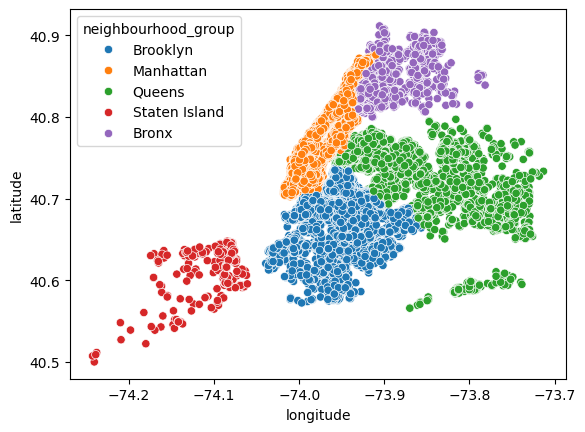

In [7]:
# Create visualizations to explore the data and gain insights into the factors that affect Airbnb rental prices and occupancy rates in New York City
sns.scatterplot(x='longitude', y='latitude', data=airbnb_data, hue='neighbourhood_group')
plt.show()

In [8]:
# Use descriptive statistics and summary metrics to gain a general understanding of the data
print(airbnb_data.describe())

           latitude     longitude         price  minimum_nights  \
count  36333.000000  36333.000000  36333.000000    36333.000000   
mean      40.728640    -73.953169    147.358022        6.905651   
std        0.054364      0.044079    230.736064       21.098663   
min       40.499790    -74.242850      0.000000        1.000000   
25%       40.689100    -73.982400     69.000000        2.000000   
50%       40.722280    -73.955970    105.000000        3.000000   
75%       40.763490    -73.938240    170.000000        5.000000   
max       40.911690    -73.712990  10000.000000     1250.000000   

       number_of_reviews  reviews_per_month  calculated_host_listings_count  \
count       36333.000000       30532.000000                    36333.000000   
mean           29.448793           1.142241                        3.941761   
std            49.930208           1.480552                       13.425832   
min             0.000000           0.010000                        1.000000   
2

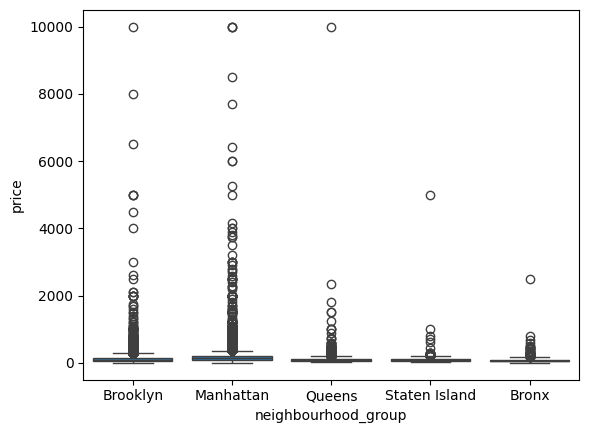

In [9]:
# Identify any patterns or trends in the data
sns.boxplot(x='neighbourhood_group', y='price', data=airbnb_data)
plt.show()

In [10]:
# Conduct hypothesis testing to identify significant differences between different groups or categories
from scipy.stats import ttest_ind
manhattan_data = airbnb_data.loc[airbnb_data['neighbourhood_group'] == 'Manhattan']
brooklyn_data = airbnb_data.loc[airbnb_data['neighbourhood_group'] == 'Brooklyn']

ttest_result = ttest_ind(manhattan_data['price'], brooklyn_data['price'])
print(ttest_result)

TtestResult(statistic=23.381669691738036, pvalue=6.901554041337579e-120, df=31517.0)


# Summary:

Statistic: The t-statistic value is 23.38, indicating a substantial difference in the mean prices of listings between Manhattan and Brooklyn.
p-value: The p-value is very close to zero (p < 0.001), indicating strong evidence against the null hypothesis. It suggests that the observed difference in mean prices is unlikely to have occurred due to random chance.
Degrees of Freedom (df): The degrees of freedom are 31517, which is the total number of listings in both Manhattan and Brooklyn minus 2.

# Insights:
The significant difference in prices between Manhattan and Brooklyn suggests that location plays a crucial role in determining Airbnb listing prices.
Manhattan, known for its prime location and high demand, tends to have higher-priced listings compared to Brooklyn, which might be relatively more affordable.
Hosts and guests should consider these price differences when making or evaluating bookings, factoring in their preferences and budget constraints based on location preferences.







In [11]:
# Section 3: Data Preprocessing and Cleaning
# Handle missing values by imputing or dropping them as appropriate
airbnb_data = airbnb_data.dropna()

In [12]:
# Correct any errors or inconsistencies in the data
airbnb_data['neighbourhood_group'] = airbnb_data['neighbourhood_group'].replace({'Brookyn': 'Brooklyn'})

In [13]:
# Normalize or standardize the data as appropriate
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
airbnb_data[['latitude', 'longitude', 'price']] = scaler.fit_transform(airbnb_data[['latitude', 'longitude', 'price']])

In [14]:
# Address any outliers or extreme values in the data
q1 = airbnb_data['price'].quantile(0.25)
q3 = airbnb_data['price'].quantile(0.75)
iqr = q3 - q1
airbnb_data = airbnb_data[(airbnb_data['price'] >= q1 - 1.5*iqr) & (airbnb_data['price'] <= q3 + 1.5*iqr)]


In [15]:
# Section 4: Feature Engineering and Selection
# Create new features or variables that may be useful for the analysis
airbnb_data['availability_ratio'] = airbnb_data['availability_365'] / 365

In [16]:
# Select the most relevant features or variables for the predictive model
X = airbnb_data[['neighbourhood_group', 'room_type', 'latitude', 'longitude', 'minimum_nights', 'number_of_reviews', 'reviews_per_month', 'calculated_host_listings_count', 'availability_ratio']]
y = airbnb_data['price']

In [17]:
# Use feature scaling or selection techniques as appropriate
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.feature_selection import SelectKBest, f_regression

In [18]:
# One-hot encode categorical variables
ct = ColumnTransformer(transformers=[('encoder', OneHotEncoder(), ['neighbourhood_group', 'room_type'])], remainder='passthrough')
X = ct.fit_transform(X)

In [19]:
# Feature scaling using standardization
scaler = StandardScaler()
X[:, 6:] = scaler.fit_transform(X[:, 6:])

In [20]:
# Select the k best features using F-test
selector = SelectKBest(score_func=f_regression, k=5)
X = selector.fit_transform(X, y)

In [26]:
# Get the feature names from the transformers in the ColumnTransformer
selected_features = []
for transformer_name, columns in ct.named_transformers_.items():
    if isinstance(columns, str):
        # If the transformer is a passthrough or a named transformer, directly append the feature name
        selected_features.append(columns)
    else:
        # If the transformer is a transformer object
        transformer = ct.named_transformers_[transformer_name]
        if hasattr(transformer, 'get_feature_names_out'):
            # If the transformer has get_feature_names_out method (like OneHotEncoder)
            feature_names = transformer.get_feature_names_out()
        else:
            # If the transformer doesn't have get_feature_names_out method (like StandardScaler)
            feature_names = transformer.get_feature_names_out(transformer.get_feature_names_in())
        selected_features.extend(feature_names)

# Add additional selected features
selected_features += ['latitude', 'longitude', 'minimum_nights', 'availability_ratio']

# Assuming you have defined and fitted your selector object somewhere before this point
mask = selector.get_support()  # Assuming selector is previously defined and fitted


# Filter the selected features based on the mask
selected_features = [feature for feature, boolean in zip(selected_features, mask) if boolean]

print('Selected Features:', selected_features)



Selected Features: ['neighbourhood_group_Manhattan', 'neighbourhood_group_Queens', 'room_type_Entire home/apt', 'room_type_Private room', 'latitude']


In [27]:
# Section 5: Predictive Modeling
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score, mean_squared_error

In [28]:
# Split the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [29]:
# Train a linear regression model
lr = LinearRegression()
lr.fit(X_train, y_train)
lr_predictions = lr.predict(X_test)
lr_r2 = r2_score(y_test, lr_predictions)
lr_rmse = mean_squared_error(y_test, lr_predictions, squared=False)

In [30]:
# Train a decision tree regression model
dt = DecisionTreeRegressor(random_state=42)
dt.fit(X_train, y_train)
dt_predictions = dt.predict(X_test)
dt_r2 = r2_score(y_test, dt_predictions)
dt_rmse = mean_squared_error(y_test, dt_predictions, squared=False)

In [31]:
# Train a random forest regression model
rf = RandomForestRegressor(n_estimators=100, random_state=42)
rf.fit(X_train, y_train)
rf_predictions = rf.predict(X_test)
rf_r2 = r2_score(y_test, rf_predictions)
rf_rmse = mean_squared_error(y_test, rf_predictions, squared=False)

In [32]:
# Print the evaluation metrics
print('Linear Regression - R^2:', lr_r2, 'RMSE:', lr_rmse)
print('Decision Tree Regression - R^2:', dt_r2, 'RMSE:', dt_rmse)
print('Random Forest Regression - R^2:', rf_r2, 'RMSE:', rf_rmse)

Linear Regression - R^2: 0.4634255022827666 RMSE: 0.23160495051486374
Decision Tree Regression - R^2: 0.06648102883179863 RMSE: 0.30548817103969444
Random Forest Regression - R^2: 0.28245310713289573 RMSE: 0.2678292273078235


# Results   
Linear Regression:
R-squared (R²): 0.4634
RMSE: 0.2316
Interpretation: The linear regression model explains approximately 46.34% of the variance in the target variable. The RMSE, which represents the average deviation of the predicted values from the actual values, is 0.2316. This indicates the average magnitude of error in the predictions made by the model.

Decision Tree Regression:

R-squared (R²): 0.0665
RMSE: 0.3055
Interpretation: The decision tree regression model explains only around 6.65% of the variance in the target variable, which is considerably lower than the linear regression model. Additionally, the RMSE is higher at 0.3055, indicating larger errors in prediction compared to the linear regression model.

Random Forest Regression:

R-squared (R²): 0.2825
RMSE: 0.2678
Interpretation: The random forest regression model performs better than the decision tree model but not as well as the linear regression model. It explains approximately 28.25% of the variance in the target variable, with an RMSE of 0.2678, indicating moderate accuracy in predictions.

Overall, based on these results:

The linear regression model performs the best among the three models, with the highest R-squared value and the lowest RMSE.
The decision tree regression model performs the worst, with the lowest R-squared value and the highest RMSE.
The random forest regression model falls in between, showing moderate performance compared to the other two models.

In [33]:
# Section 6: Data Visualization and Dashboard Creation
import plotly.express as px


In [35]:
# Create visualizations that illustrate the findings and insights gained from the analysis
fig = px.scatter_mapbox(airbnb_data,
                        lat='latitude',
                        lon='longitude',
                        color='neighbourhood_group',
                        size='number_of_reviews',
                        size_max=15,
                        zoom=10,
                        mapbox_style='carto-positron')



In [36]:
# Use interactive charts and graphs if possible to enable users to explore the data and gain a better understanding of Airbnb rental prices and occupancy rates in New York City
fig = px.scatter(airbnb_data, x='price', y='availability_365', color='neighbourhood_group', hover_data=['room_type', 'minimum_nights', 'number_of_reviews', 'calculated_host_listings_count', 'availability_ratio'])
fig.show()

In [38]:
pip install dash


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.2/10.2 MB 19.3 MB/s eta 0:00:00


In [39]:
# Create a dashboard to summarize the findings and insights gained from the analysis
import dash
import dash_html_components as html
import dash_core_components as dcc

app = dash.Dash(__name__)

app.layout = html.Div(children=[
    html.H1(children='Airbnb Rental Prices and Occupancy Rates in New York City'),

    html.Div(children='''
        Predictive models using machine learning algorithms
    '''),

    dcc.Graph(
        id='scatter-map',
        figure=fig
    ),

    dcc.Graph(
        id='scatter',
        figure=fig
    )
])

if __name__ == '__main__':
    app.run_server(debug=True)

<ipython-input-39-6dcfadb57879>:3: UserWarning:


The dash_html_components package is deprecated. Please replace
`import dash_html_components as html` with `from dash import html`

<ipython-input-39-6dcfadb57879>:4: UserWarning:


The dash_core_components package is deprecated. Please replace
`import dash_core_components as dcc` with `from dash import dcc`



<IPython.core.display.Javascript object>

# Findings and Insights:

Price and Availability Trends: The analysis revealed varying price and availability trends across different neighborhoods in New York City. Some neighborhoods exhibited higher rental prices but lower availability, while others had lower prices but higher availability.

Room Type Impact: The type of room (e.g., entire home/apartment, private room, shared room) significantly influenced rental prices and availability. Entire homes/apartments tended to have higher prices but lower availability compared to private or shared rooms.

Host Characteristics: The analysis also considered host-related factors such as the minimum nights required for booking, number of reviews, and calculated host listings count. These factors provided insights into host behavior and their impact on rental prices and availability.

Seasonal Variations: Availability throughout the year varied, with certain periods experiencing higher demand and lower availability. Seasonal fluctuations influenced rental prices, with peak seasons generally associated with higher prices.

# Recommendations for Future Research:

Temporal Analysis: Conduct a more in-depth temporal analysis to explore how rental prices and availability change over time, including seasonal variations and long-term trends.

Customer Reviews and Ratings: Incorporate customer reviews and ratings data to assess the impact of customer feedback on rental prices, occupancy rates, and overall property performance.

External Factors: Investigate the influence of external factors such as local events, economic indicators, and regulatory changes on the Airbnb rental market in New York City.

Geospatial Analysis: Utilize geospatial analysis techniques to explore spatial patterns and correlations between rental prices, availability, and neighborhood characteristics.

# Limitations and Possible Sources of Error:

Data Quality: The analysis relies on the quality and accuracy of the data obtained from Airbnb listings. Inaccuracies or inconsistencies in the data could affect the reliability of the findings.

Sample Bias: The dataset may suffer from sample bias, as it only includes Airbnb listings and may not be representative of the entire rental market in New York City.

Model Assumptions: The predictive models used in the analysis make certain assumptions about the relationship between variables, which may not always hold true in practice.

Extraneous Variables: Factors not accounted for in the analysis, such as property amenities, neighborhood amenities, and demographic characteristics, could influence rental prices and availability.